<a href="https://colab.research.google.com/github/jchen0000/widsdatathon2025/blob/main/python/Lasso_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [21]:
# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')


# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# Patient ID
patient_id = train_sol.iloc[:, 0]

# Import train MRI data (1213, 19901)
train_mri_filepath = "drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
train_mri = pd.read_csv(train_mri_filepath)

# Remove first line, convert csv file to a functional connectome matrix
train_matrix_data = train_mri.iloc[:, 1:].to_numpy(dtype=float)  # (1213, 19900)

# Import Train Data
!wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx?raw=true" -O train_cat2.xlsx
train_cat2 = pd.read_excel("train_cat2.xlsx")      # (1213, 10)

!wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_QUANTITATIVE_METADATA_imputed_Jing.xlsx?raw=true" -O train_quant2.xlsx
train_quant2 = pd.read_excel("train_quant2.xlsx")  # (1213, 19)

# Merge train datasets on the participant ID
combined_train_data2 = pd.merge(train_cat2, train_quant2, on='participant_id')
train_with_outcome2 = pd.merge(combined_train_data2, train_sol, on='participant_id')  # (1213, 30)

# Combine metadata and fMRI into one feature matrix
features2 = np.hstack([combined_train_data2, train_matrix_data])

# Remove patient ID
combined_metadata_imputed = features2[:, 1:]
combined_metadata_imputed = combined_metadata_imputed.astype(float)  # (1213, 19927)



# Import test MRI data
test_mri_filepath = "drive/My Drive/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_mri = pd.read_csv(test_mri_filepath)

# Remove first line, convert csv file to a functional connectome matrix
test_matrix_data = test_mri.iloc[:, 1:].to_numpy(dtype=float)  # (304, 19900)

# Import test Data
!wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx?raw=true" -O test_cat2.xlsx
test_cat2 = pd.read_excel("test_cat2.xlsx")      # (304, 28)

!wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TEST_QUANTITATIVE_METADATA_imputed_Jing_new.xlsx?raw=true" -O test_quant2.xlsx
test_quant2 = pd.read_excel("test_quant2.xlsx")  # (304, 28)

# Merge test datasets on the participant ID
combined_test_data2 = pd.merge(test_cat2, test_quant2, on='participant_id')
test_no_id2 = combined_test_data2.drop(columns=['participant_id'])

test_patient_ids = combined_test_data2['participant_id'].values  # Extract patient IDs using column name

# Combine metadata and fMRI into one feature matrix
test_features2 = np.hstack([combined_test_data2, test_matrix_data])


# Remove patient ID
combined_test_metadata_imputed = test_features2[:, 1:]
combined_test_metadata_imputed = combined_test_metadata_imputed.astype(float)  # (304, 19927)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-04-19 15:48:26--  https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx [following]
--2025-04-19 15:48:26--  https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jchen0000/widsdatathon2025/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx [following]
--2025-04-19

In [30]:
import pandas as pd

# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# Import test data
!wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx?raw=true" -O test_cat2.xlsx
test_cat2 = pd.read_excel("test_cat2.xlsx")

# Test patient id
test_patient_ids = test_cat2['participant_id'].values  # Extract patient IDs using column name

# Import standardized lasso data
combined_metadata_imputed = pd.read_csv('/content/drive/My Drive/widsdatathon2025/Work/Processed Data/lasso_standardized_train.csv')
combined_test_metadata_imputed = pd.read_csv('/content/drive/My Drive/widsdatathon2025/Work/Processed Data/lasso_standardized_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-04-19 16:02:12--  https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx [following]
--2025-04-19 16:02:13--  https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jchen0000/widsdatathon2025/refs/heads/main/data/train/TEST_CATEGORICAL_METADATA_imputed_Jing_new.xlsx [following]


# Neural Network

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# --- Define the function to compute weighted F1 score ---
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Compute the final weighted F1 score for the competition.
    Female ADHD cases (where ADHD_Outcome==1 and Sex_F==1) are given 2x weight.
    The final score is the average of the weighted F1 for ADHD_Outcome and the F1 for Sex_F.
    """
    # Create sample weights for ADHD_Outcome: weight=2 for female ADHD cases, else 1.
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0

    # Calculate weighted F1 for ADHD_Outcome
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    # Calculate standard F1 for Sex_F
    f1_sex = f1_score(y_true_sex, y_pred_sex)

    # Final leaderboard score: average of the two F1 scores
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex

# --- Prepare the data ---
# Use combined_metadata_imputed as input features.
X = combined_metadata_imputed  # (1213, 19927)
# Extract targets from train_sol:
y_adhd = train_sol['ADHD_Outcome'].values  # Binary labels (0 or 1)
y_sex  = train_sol['Sex_F'].values         # Binary labels (0 or 1)

# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets.
# Note: We split the labels separately but the splits will be aligned because we use the same X_scaled.
X_train_split, X_val_split, y_train_adhd_split, y_val_adhd_split = train_test_split(
    X_scaled, y_adhd, test_size=0.2, random_state=42
)
_, _, y_train_sex_split, y_val_sex_split = train_test_split(
    X_scaled, y_sex, test_size=0.2, random_state=42
)

# --- Build the multi-output neural network model ---
input_layer = Input(shape=(X_train_split.shape[1],))
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)

# Two separate output layers:
output_adhd = Dense(1, activation='sigmoid', name='adhd_output')(x)
output_sex  = Dense(1, activation='sigmoid', name='sex_output')(x)

model = Model(inputs=input_layer, outputs=[output_adhd, output_sex])

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics={'adhd_output': 'accuracy', 'sex_output': 'accuracy'})


# Set up early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the model ---
history = model.fit(
    X_train_split,
    {'adhd_output': y_train_adhd_split, 'sex_output': y_train_sex_split},
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, {'adhd_output': y_val_adhd_split, 'sex_output': y_val_sex_split}),
    callbacks=[early_stopping]
)

# --- Evaluate the model ---
results = model.evaluate(X_val_split, {'adhd_output': y_val_adhd_split, 'sex_output': y_val_sex_split})
print("Evaluation Results:", results)

# --- Make predictions on the validation set ---
predictions = model.predict(X_val_split)
# predictions is a list: predictions[0] for ADHD_Outcome, predictions[1] for Sex_F.
y_val_pred_adhd = (predictions[0] > 0.5).astype(int).flatten()
y_val_pred_sex  = (predictions[1] > 0.5).astype(int).flatten()

# --- Compute the weighted F1 score ---
final_f1, f1_adhd, f1_sex = compute_weighted_f1(y_val_adhd_split, y_val_pred_adhd, y_val_sex_split, y_val_pred_sex)

print(f"ADHD F1 Score (weighted): {f1_adhd:.4f}")
print(f"Sex_F F1 Score: {f1_sex:.4f}")
print(f"Final Weighted F1 Score: {final_f1:.4f}")



Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - adhd_output_accuracy: 0.4904 - adhd_output_loss: 0.7960 - loss: 5.5081 - sex_output_accuracy: 0.4674 - sex_output_loss: 0.8731 - val_adhd_output_accuracy: 0.5103 - val_adhd_output_loss: 0.8350 - val_loss: 5.4751 - val_sex_output_accuracy: 0.5309 - val_sex_output_loss: 0.8097
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - adhd_output_accuracy: 0.5632 - adhd_output_loss: 0.7128 - loss: 5.2485 - sex_output_accuracy: 0.5165 - sex_output_loss: 0.7581 - val_adhd_output_accuracy: 0.5679 - val_adhd_output_loss: 0.6764 - val_loss: 5.0149 - val_sex_output_accuracy: 0.6049 - val_sex_output_loss: 0.7175
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - adhd_output_accuracy: 0.6290 - adhd_output_loss: 0.6532 - loss: 4.9308 - sex_output_accuracy: 0.5691 - sex_output_loss: 0.7174 - val_adhd_output_accuracy: 0.6831 - val_adhd_output_loss: 0.6398 - val_loss: 4.7004 - val_sex_output_accuracy: 0.6502 - val_sex_output_loss: 0.6751
Epoch 4/10

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ADHD F1 Score (weighted): 0.8312
Sex_F F1 Score: 0.2623
Final Weighted F1 Score: 0.5468


# Threshold Tuning

In [18]:
# For ADHD:
#    y_val_adhd_prob: predicted probabilities from the model for ADHD_Outcome (shape: (n_samples,))
#    y_val_adhd: true ADHD_Outcome labels (0 or 1)
# For Sex_F:
#    y_val_sex_prob: predicted probabilities from the model for Sex_F (shape: (n_samples,))
#    y_val_sex: true Sex_F labels (0 or 1)

y_val_adhd_prob = predictions[0].flatten()
y_val_sex_prob  = predictions[1].flatten()

# --- Define the function to compute weighted F1 score ---
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Compute the final weighted F1 score.
    Female ADHD cases (where ADHD_Outcome==1 and Sex_F==1) are given 2x weight.
    Returns:
       final_f1: the average of the weighted ADHD F1 and the Sex_F F1.
       f1_adhd: F1 score for ADHD_Outcome using sample weights.
       f1_sex:  F1 score for Sex_F (unweighted).
    """
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    f1_sex = f1_score(y_true_sex, y_pred_sex)
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex

# --- Define a range of thresholds to test ---
#thresholds = np.linspace(0, 1, 101)  # from 0.00 to 1.00 in steps of 0.01
thresholds = np.linspace(0.1, 0.99, 90)

best_final_f1 = 0.0
best_thr_adhd = 0.0
best_thr_sex  = 0.0
best_f1_adhd = 0.0
best_f1_sex  = 0.0

# --- Perform a 2D threshold sweep ---
for thr_a in thresholds:
    for thr_s in thresholds:
        y_pred_adhd = (y_val_adhd_prob > thr_a).astype(int)
        y_pred_sex  = (y_val_sex_prob > thr_s).astype(int)
        final_f1, f1_adhd, f1_sex = compute_weighted_f1(y_val_adhd_split, y_pred_adhd, y_val_sex_split, y_pred_sex)
        if final_f1 > best_final_f1:
            best_final_f1 = final_f1
            best_thr_adhd = thr_a
            best_thr_sex  = thr_s
            best_f1_adhd = f1_adhd
            best_f1_sex  = f1_sex

print(f"Best ADHD Threshold: {best_thr_adhd:.2f} with F1: {best_f1_adhd:.4f}")
print(f"Best Sex_F Threshold: {best_thr_sex:.2f} with F1: {best_f1_sex:.4f}")
print(f"Best Final Weighted F1: {best_final_f1:.4f}")



Best ADHD Threshold: 0.10 with F1: 0.8728
Best Sex_F Threshold: 0.14 with F1: 0.4577
Best Final Weighted F1: 0.6653


In [31]:

# ----------------------------
# 1. Prepare Test Features
# ----------------------------
# test_features was constructed as follows:
# - combined_test_data and test_matrix_data were merged to form a matrix.
# - "NA" values were replaced with np.nan.
# - The first column (patient IDs) was separated.
# - Missing values were imputed (e.g., using KNN imputation).
#
# In your code, you ended with:
# combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)
# and then:
# test_features = np.hstack([test_patient_ids.reshape(-1, 1), test_features_no_id])
#
# For prediction, we want to use the imputed features that match the training data.
# Apply the same StandardScaler (fitted on the training data) to the test features.
final_test_features = scaler.transform(combined_test_metadata_imputed)  # Shape: (n_test_samples, n_features)

# ----------------------------
# 2. Make Predictions on Test Data
# ----------------------------
# Using the multi-output model, predictions will be a list of arrays:
#   test_predictions[0] corresponds to ADHD_Outcome probabilities.
#   test_predictions[1] corresponds to Sex_F probabilities.
test_predictions = model.predict(final_test_features)

# Flatten the predictions (if needed) so they are 1D arrays:
adhd_probs = test_predictions[0].flatten()
sex_probs  = test_predictions[1].flatten()

# ----------------------------
# 3. Apply Optimal Thresholds
# ----------------------------
# Use the optimal thresholds found from threshold tuning.
# (For example, these variables should have been computed during your threshold tuning process.)
test_pred_adhd = (adhd_probs > best_thr_adhd).astype(int)
test_pred_sex  = (sex_probs > best_thr_sex).astype(int)

# ----------------------------
# 4. Create the Submission DataFrame
# ----------------------------
# Ensure that test_patient_ids is a 1D array containing the IDs.
submission_df = pd.DataFrame({
    'participant_id': test_patient_ids.flatten(),  # Use your test IDs
    'ADHD_Outcome': test_pred_adhd,
    'Sex_F': test_pred_sex
})

# ----------------------------
# 5. Save to CSV
# ----------------------------
submission_df.to_csv('/content/drive/My Drive/widsdatathon2025/Work/Submission/submission.csv', index=False)
print("Submission file saved as submission.csv")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Submission file saved as submission.csv


# Threshold Tuning Graph

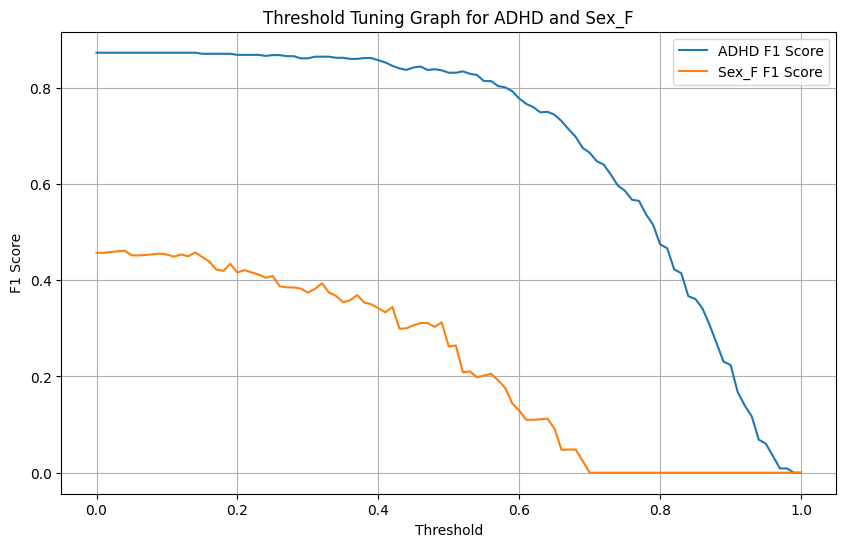

In [13]:
# prompt: generate a threshold tuning graph for ADHD and Sex_F

import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Assuming y_val_adhd_prob, y_val_sex_prob, y_val_adhd_split, and y_val_sex_split are defined as in your code.

# Function to compute the weighted F1 score (same as before)
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    f1_sex = f1_score(y_true_sex, y_pred_sex)
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex


thresholds = np.linspace(0, 1, 101)
f1_scores_adhd = []
f1_scores_sex = []

for threshold in thresholds:
    y_pred_adhd = (y_val_adhd_prob > threshold).astype(int)
    y_pred_sex = (y_val_sex_prob > threshold).astype(int)
    _, f1_adhd, f1_sex = compute_weighted_f1(y_val_adhd_split, y_pred_adhd, y_val_sex_split, y_pred_sex)
    f1_scores_adhd.append(f1_adhd)
    f1_scores_sex.append(f1_sex)

# Plotting the threshold tuning graph
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores_adhd, label='ADHD F1 Score')
plt.plot(thresholds, f1_scores_sex, label='Sex_F F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold Tuning Graph for ADHD and Sex_F')
plt.legend()
plt.grid(True)
plt.show()


# Two Model Data Processing: Train metadata + fmri with no or few missing values

In [41]:
# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Import train categorical data (1213, 10)
train_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
# train_cat.shape
# train_cat.describe()

# Import train quantitative data (1213, 19)
train_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
# train_quant.shape
# train_quant.describe()

# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
# train_sol.shape
# train_sol.describe()

# Merge train datasets on the participant ID
combined_train_data = pd.merge(train_cat, train_quant, on='participant_id')    # (1213, 28)
train_with_outcome = pd.merge(combined_train_data, train_sol, on='participant_id')  # (1213, 30)

# # Extract metadata from combined_train_data (skip the participant ID)
# metadata = combined_train_data.iloc[:, 1:].to_numpy()  # shape: (1213, 27)

# # Standardize metadata
# scaler_meta = StandardScaler()
# metadata_scaled = scaler_meta.fit_transform(metadata)

# Import test categorical data (304, 10)
test_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

# Import test quantitative data (304, 19)
test_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Merge test datasets on the participant ID  (304, 28)
combined_test_data = pd.merge(test_cat, test_quant, on='participant_id')
test_no_id = combined_test_data.drop(columns=['participant_id'])

# Import train MRI data (1213, 19901)
train_mri_filepath = "drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
train_mri = pd.read_csv(train_mri_filepath)

# Import test MRI data
test_mri_filepath = "drive/My Drive/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_mri = pd.read_csv(test_mri_filepath)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from sklearn.impute import KNNImputer


# Remove first line, convert csv file to a functional connectome matrix
train_matrix_data = train_mri.iloc[:, 1:].to_numpy(dtype=float)

# Calculate the percentage of missing values in each column
missing_percentage = combined_train_data.isnull().sum() / len(combined_train_data) * 100

missing_percentage

# Identify columns with more than a certain percentage threshold of missing values
threshold = 1  # meaning 1%
columns_to_remove = missing_percentage[missing_percentage > threshold].index

# Extract columns with massive missing values
extracted_columns = combined_train_data[columns_to_remove]         # (1213, 9)

# Extract columns with no or few missing values
columns_few_missing = combined_train_data.drop(columns=columns_to_remove)     # (1213, 19)

# Combine columns_few_missing with fmri
features_few_missing = np.hstack([columns_few_missing, train_matrix_data])

# Replace "NA" with np.nan
features_few_missing[features_few_missing == "NA"] = np.nan

# Remove Patient ID
features_few_missing = features_few_missing[:, 1:]

# Convert the features_few_missing to float
features_few_missing = features_few_missing.astype(float)

# Impute missing values with KNN imputation
imputer_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
combined_metadata_imputed2 = imputer_metadata.fit_transform(features_few_missing)  # (1213, 19918)


In [39]:
combined_metadata_imputed2.shape

(1213, 19927)